In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
os.environ["LAL_DATA_PATH"] = "../data"

In [3]:
import bilby.gw
import gwpy
import h5py
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate

/Users/wfarr/Research/Memory/.venv/lib/python3.11/site-packages/gwpy/time/_ligotimegps.py:42: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [4]:
from __future__ import annotations

import ast
import logging
import re
from dataclasses import dataclass
from typing import Any, Dict, Iterable, Iterator, List, Optional, Tuple

import numpy as np

from pesummary.io import read as pesummary_read
from gwosc.datasets import event_gps, event_detectors, find_datasets
from gwpy.timeseries import TimeSeries

import bilby
from bilby.gw.detector.psd import PowerSpectralDensity
from bilby.gw.detector import InterferometerList
from bilby.gw.waveform_generator import WaveformGenerator


LOGGER = logging.getLogger("pesummary_residuals")


@dataclass
class AnalysisConfig:
    """Configuration for gravitational wave analysis."""
    label: str
    event: str
    detectors: Tuple[str, ...]
    trigger_time: float
    start_time: float
    end_time: float
    duration: float
    sampling_frequency: float
    minimum_frequency: Dict[str, float]
    maximum_frequency: Optional[Dict[str, float]]
    reference_frequency: float
    waveform_approximant: str


# ----------------------------
# Generic parsing helpers
# ----------------------------

def _as_float(x: Any, default: Optional[float] = None) -> Optional[float]:
    """Convert value to float with fallback."""
    if x is None:
        return default
    if isinstance(x, (float, int, np.floating, np.integer)):
        return float(x)
    s = str(x).strip()
    try:
        return float(s)
    except ValueError:
        return default


def _maybe_literal(x: Any) -> Any:
    """Try to parse strings that are dict/list/numeric literals."""
    if not isinstance(x, str):
        return x
    s = x.strip()
    try:
        return ast.literal_eval(s)
    except Exception:
        return x


def _get_cfg(cfg: Dict[str, Dict[str, Any]], section: str, key: str, default=None):
    """Get config value from section/key with fallback."""
    if section not in cfg or key not in cfg[section]:
        return default
    return _maybe_literal(cfg[section][key])


def _cfg_first_match(cfg: Dict[str, Dict[str, Any]], section: str, keys: List[str], default=None):
    """Find first matching key in config section."""
    sec = cfg.get(section, {})
    for k in keys:
        if k in sec:
            return _maybe_literal(sec[k])
    return default


def _parse_ifo_freq_dict(value: Any, detectors: Iterable[str], default: float) -> Dict[str, float]:
    """
    Parse a frequency specification that might be:
      - a float / int
      - a numeric string
      - a dict-like string: "{'H1': 20, 'L1': 20}" or "{H1: 20, L1: 20}"
      - a dict already
    Returns per-IFO dict with fallback default.
    """
    out = {d: float(default) for d in detectors}
    if value is None:
        return out

    value = _maybe_literal(value)

    if isinstance(value, (float, int, np.floating, np.integer)):
        return {d: float(value) for d in detectors}

    if isinstance(value, str):
        f = _as_float(value, None)
        if f is not None:
            return {d: float(f) for d in detectors}

        # Try to handle dict-like strings with bare keys
        s = value.strip()
        if s.startswith("{") and s.endswith("}"):
            for d in detectors:
                s = s.replace(f"{d}:", f"'{d}':")
            try:
                dct = ast.literal_eval(s)
                if isinstance(dct, dict):
                    for d in detectors:
                        if d in dct:
                            out[d] = float(dct[d])
                    return out
            except Exception:
                return out

        return out

    if isinstance(value, dict):
        for d in detectors:
            if d in value:
                out[d] = float(value[d])
        return out

    return out


def _choose_label(data, label: Optional[str]) -> str:
    """Choose analysis label from data or default to first."""
    if label is not None:
        return label
    if len(data.labels) == 1:
        return data.labels[0]
    return data.labels[0]


# ----------------------------
# GWOSC strain helpers
# ----------------------------

def _select_gwosc_dataset(start: float, end: float, fs: float) -> Optional[str]:
    """Select appropriate GWOSC dataset based on time segment and sampling frequency."""
    seg = (int(np.floor(start)), int(np.ceil(end)))
    runs = find_datasets(type="run", segment=seg)
    if not runs:
        return None
    want_4k = fs <= 4096 + 1e-6
    for r in runs:
        ru = r.upper()
        if want_4k and "4KHZ" in ru:
            return r
        if (not want_4k) and "16KHZ" in ru:
            return r
    return runs[0]


def _download_gwosc_strain(detectors: Iterable[str], start: float, end: float, fs: float) -> Dict[str, TimeSeries]:
    """Download GWOSC open strain data for specified detectors and time range."""
    dataset = _select_gwosc_dataset(start, end, fs)
    out: Dict[str, TimeSeries] = {}
    for det in detectors:
        LOGGER.info("Fetching GWOSC open strain: %s [%s, %s), dataset=%s", det, start, end, dataset)
        if dataset is None:
            ts = TimeSeries.fetch_open_data(det, start, end, cache=True, verbose=True)
        else:
            ts = TimeSeries.fetch_open_data(det, start, end, cache=True, verbose=True, dataset=dataset)
        out[det] = ts
    return out


def _infer_waveform_approximant_from_config(cfg_dict: Dict[str, Dict[str, Any]], default: str = "IMRPhenomPv2") -> str:
    """Infer waveform approximant from config, trying multiple naming conventions."""
    # Try flattened bilby_pipe style
    val = _cfg_first_match(cfg_dict, "config", ["waveform-approximant", "waveform_approximant", "approximant"], default=None)
    if val is not None:
        return str(val)

    # Try older sectioned style
    val = _cfg_first_match(cfg_dict, "waveform", ["waveform-approximant", "waveform_approximant", "approximant"], default=None)
    if val is not None:
        return str(val)

    # Fallback: scan any section for approximant key
    for section, sec in cfg_dict.items():
        if not isinstance(sec, dict):
            continue
        for k, v in sec.items():
            if "approximant" in str(k).lower() and "injection" not in str(k).lower():
                return str(_maybe_literal(v))

    return str(default)


# ----------------------------
# Config -> AnalysisConfig
# ----------------------------

def _parse_analysis_config(data, label: str, event: str) -> AnalysisConfig:
    """Parse PESummary config into AnalysisConfig dataclass."""
    cfg = data.config[label]

    dets = _get_cfg(cfg, "data", "detectors", None)
    if dets is None:
        detectors = tuple(sorted(event_detectors(event)))
    else:
        dets = _maybe_literal(dets)
        if isinstance(dets, str):
            try:
                detectors = tuple(ast.literal_eval(dets))
            except Exception:
                detectors = tuple(dets.replace(",", " ").split())
        else:
            detectors = tuple(dets)

    trig = float(event_gps(event))

    duration = float(_get_cfg(cfg, "data", "duration", 4.0))
    sampling_frequency = float(_get_cfg(cfg, "data", "sampling_frequency", 4096))

    start_time_cfg = _as_float(_get_cfg(cfg, "data", "start_time", None), None)
    end_time_cfg = _as_float(_get_cfg(cfg, "data", "end_time", None), None)
    if start_time_cfg is not None and end_time_cfg is not None:
        start_time, end_time = start_time_cfg, end_time_cfg
    else:
        start_time = trig - duration / 2.0
        end_time = trig + duration / 2.0

    min_freq = _parse_ifo_freq_dict(_get_cfg(cfg, "analysis", "minimum_frequency", 20), detectors, default=20.0)

    max_freq_val = _get_cfg(cfg, "analysis", "maximum_frequency", None)
    max_freq = None
    if max_freq_val is not None:
        max_freq = _parse_ifo_freq_dict(max_freq_val, detectors, default=float(sampling_frequency / 2.0))

    reference_frequency = float(_get_cfg(cfg, "waveform", "reference_frequency", 50.0))
    waveform_approximant = _infer_waveform_approximant_from_config(cfg, default="IMRPhenomPv2")

    return AnalysisConfig(
        label=label,
        event=event,
        detectors=detectors,
        trigger_time=trig,
        start_time=float(start_time),
        end_time=float(end_time),
        duration=float(duration),
        sampling_frequency=float(sampling_frequency),
        minimum_frequency=min_freq,
        maximum_frequency=max_freq,
        reference_frequency=float(reference_frequency),
        waveform_approximant=waveform_approximant,
    )


# ----------------------------
# Spline calibration settings from config
# ----------------------------

def _infer_spline_npoints_from_config(cfg_dict: Dict[str, Dict[str, Any]], default: int = 10) -> int:
    """Infer number of spline calibration points from config."""
    candidates = [
        "spline_calibration_npoints",
        "spline_calibration_n_points",
        "spline_calibration_points",
        "calibration_npoints",
        "calibration_n_points",
        "npoints",
        "n_points",
        "recalib_npoints",
        "recalib_n_points",
        "spline_npoints",
        "spline_n_points",
    ]

    for section in ("calibration", "analysis", "likelihood", "data"):
        val = _cfg_first_match(cfg_dict, section, candidates, default=None)
        if val is not None:
            try:
                return int(val)
            except Exception:
                pass

    # Last resort: look for any "*npoint*" key in [calibration]
    for k, v in cfg_dict.get("calibration", {}).items():
        if "npoint" in str(k).lower():
            try:
                return int(_maybe_literal(v))
            except Exception:
                continue

    return int(default)


def _infer_calib_minmax_freq_from_config(
    cfg_dict: Dict[str, Dict[str, Any]],
    detectors: Tuple[str, ...],
) -> Tuple[Dict[str, float], Dict[str, float]]:
    """Infer per-IFO calibration spline min/max frequencies from config."""
    min_keys = [
        "calibration_minimum_frequency",
        "calibration_minimum_frequency_dict",
        "spline_calibration_minimum_frequency",
        "spline_calibration_minimum_frequency_dict",
        "minimum_frequency_calibration",
        "minimum_frequency_calibration_dict",
        "spline_minimum_frequency",
    ]
    max_keys = [
        "calibration_maximum_frequency",
        "calibration_maximum_frequency_dict",
        "spline_calibration_maximum_frequency",
        "spline_calibration_maximum_frequency_dict",
        "maximum_frequency_calibration",
        "maximum_frequency_calibration_dict",
        "spline_maximum_frequency",
    ]

    min_val = _cfg_first_match(cfg_dict, "calibration", min_keys, default=None)
    max_val = _cfg_first_match(cfg_dict, "calibration", max_keys, default=None)

    min_dict: Dict[str, float] = {}
    max_dict: Dict[str, float] = {}

    if min_val is not None:
        parsed = _parse_ifo_freq_dict(min_val, detectors, default=np.nan)
        min_dict = {k: float(v) for k, v in parsed.items() if np.isfinite(v)}

    if max_val is not None:
        parsed = _parse_ifo_freq_dict(max_val, detectors, default=np.nan)
        max_dict = {k: float(v) for k, v in parsed.items() if np.isfinite(v)}

    return min_dict, max_dict


def _attach_spline_calibration_from_config(
    ifos: InterferometerList,
    cfg_dict: Dict[str, Dict[str, Any]],
    detectors: Tuple[str, ...],
    *,
    base_prefix: str = "recalib_",
    default_n_points: int = 10,
) -> Dict[str, Any]:
    """
    Attach bilby CubicSpline calibration models to interferometers.
    
    Uses per-IFO prefix like 'recalib_H1_' to match parameter naming conventions.
    """
    n_points = _infer_spline_npoints_from_config(cfg_dict, default=default_n_points)
    cal_min_dict, cal_max_dict = _infer_calib_minmax_freq_from_config(cfg_dict, detectors)

    info = {"n_points": int(n_points), "per_ifo": {}}

    for ifo in ifos:
        min_f = float(cal_min_dict.get(ifo.name, ifo.minimum_frequency))

        if getattr(ifo, "maximum_frequency", None) is None:
            ifo_max_default = float(ifo.strain_data.sampling_frequency / 2.0)
        else:
            ifo_max_default = float(ifo.maximum_frequency)

        max_f = float(cal_max_dict.get(ifo.name, ifo_max_default))
        if max_f <= min_f:
            raise ValueError(
                f"Invalid calibration spline frequency bounds for {ifo.name}: "
                f"min_f={min_f}, max_f={max_f}."
            )

        per_ifo_prefix = f"{base_prefix}{ifo.name}_"

        ifo.calibration_model = bilby.gw.detector.calibration.CubicSpline(
            prefix=per_ifo_prefix,
            minimum_frequency=min_f,
            maximum_frequency=max_f,
            n_points=int(n_points),
        )

        info["per_ifo"][ifo.name] = {"prefix": per_ifo_prefix, "min_f": min_f, "max_f": max_f}

    return info


def _check_expected_spline_keys(sample: Dict[str, Any], ifos: InterferometerList) -> None:
    """Validate that posterior sample contains expected calibration parameter keys."""
    n = int(ifos[0].calibration_model.n_points)
    for ifo in ifos:
        pref = ifo.calibration_model.prefix
        for i in range(n):
            for kind in ("amplitude", "phase"):
                k = f"{pref}{kind}_{i}"
                if k not in sample:
                    near = [kk for kk in sample.keys() if ifo.name in kk and 
                           ("amp" in kk.lower() or "phase" in kk.lower() or 
                            "phi" in kk.lower() or "recalib" in kk.lower())]
                    near = sorted(near)[:60]
                    raise KeyError(
                        f"Missing calibration key '{k}' in posterior sample.\n"
                        f"Expected bilby spline keys like '{pref}amplitude_0' and '{pref}phase_0'.\n"
                        f"Some nearby keys (first 60):\n" + "\n".join(near)
                    )


# ----------------------------
# bilby objects
# ----------------------------

def _build_waveform_generator_bbh(cfg: AnalysisConfig) -> WaveformGenerator:
    """Build bilby WaveformGenerator for binary black hole signals."""
    waveform_arguments = dict(
        waveform_approximant=cfg.waveform_approximant,
        reference_frequency=cfg.reference_frequency,
    )
    return WaveformGenerator(
        duration=cfg.duration,
        sampling_frequency=cfg.sampling_frequency,
        frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
        parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
        waveform_arguments=waveform_arguments,
    )


def _build_ifos_with_psd_and_strain(
    data,
    cfg: AnalysisConfig,
) -> InterferometerList:
    """Build interferometer list with PSDs and strain data."""
    # Download GWOSC open strain
    strain = _download_gwosc_strain(cfg.detectors, cfg.start_time, cfg.end_time, cfg.sampling_frequency)

    # Build IFO objects and set strain
    ifos = InterferometerList([])
    for det in cfg.detectors:
        ifo = bilby.gw.detector.get_empty_interferometer(det)
        ifo.minimum_frequency = float(cfg.minimum_frequency[det])
        if cfg.maximum_frequency is not None:
            ifo.maximum_frequency = float(cfg.maximum_frequency[det])

        ifo.strain_data.set_from_gwpy_timeseries(strain[det])
        ifos.append(ifo)

    # Attach PSDs embedded in PESummary
    psd_dict = data.psd[cfg.label]
    for ifo in ifos:
        psd = psd_dict[ifo.name]
        freq = np.asarray(psd.frequencies)
        psd_vals = np.asarray(psd.strains)
        ifo.power_spectral_density = PowerSpectralDensity(
            frequency_array=freq,
            psd_array=psd_vals,
        )

    return ifos


# ----------------------------
# Calibration key handling
# ----------------------------

_CAL_KIND_SYNONYMS = {
    "amplitude": ["amplitude", "amp", "dA", "deltaA", "delta_amplitude"],
    "phase": ["phase", "phi", "dphi", "deltaPhi", "delta_phase"],
}


def _find_cal_key(sample_keys: List[str], ifo: str, kind: str, i: int) -> Optional[str]:
    """
    Find calibration parameter key in posterior sample.
    
    Supports multiple naming conventions:
      - recalib_H1_amplitude_0
      - H1_recalib_amplitude_0
      - recalib_H1_amp_0
      - etc.
    """
    syns = _CAL_KIND_SYNONYMS[kind]

    idx_pat = rf"(?:_{i}\b|{i}\b)"

    candidates = []
    for k in sample_keys:
        kl = k.lower()
        if ifo.lower() not in kl:
            continue
        if not any(s.lower() in kl for s in syns):
            continue
        if re.search(idx_pat, kl) is None:
            continue
        candidates.append(k)

    if not candidates:
        return None

    # Prefer exact bilby naming
    want = f"recalib_{ifo}_{kind}_{i}"
    if want in candidates:
        return want

    # Prefer keys starting with recalib_{ifo}_
    pref = f"recalib_{ifo}_"
    starts = [k for k in candidates if k.startswith(pref)]
    if len(starts) == 1:
        return starts[0]
    if len(starts) > 1:
        full_kind = [k for k in starts if kind in k.lower()]
        if len(full_kind) == 1:
            return full_kind[0]
        return sorted(starts)[0]

    return sorted(candidates)[0]


def _ensure_bilby_calibration_keys(
    sample: Dict[str, Any],
    ifo_names: Tuple[str, ...],
    n_points: int,
) -> Dict[str, Any]:
    """
    Return a copy of sample with calibration keys normalized to bilby conventions.
    
    Adds aliases so bilby CubicSpline can find:
      recalib_{IFO}_amplitude_i and recalib_{IFO}_phase_i
    """
    keys = list(sample.keys())
    out = dict(sample)

    for ifo in ifo_names:
        for kind in ("amplitude", "phase"):
            for i in range(int(n_points)):
                expected = f"recalib_{ifo}_{kind}_{i}"
                if expected in out:
                    continue

                found = _find_cal_key(keys, ifo=ifo, kind=kind, i=i)
                if found is None:
                    nearby = [k for k in keys if ifo in k and 
                             ("cal" in k.lower() or "amp" in k.lower() or 
                              "phase" in k.lower() or "phi" in k.lower())]
                    nearby = sorted(nearby)[:40]
                    raise KeyError(
                        f"Could not find a posterior key for {expected}.\n"
                        f"bilby expects keys like 'recalib_{ifo}_{kind}_{i}'.\n"
                        f"Here are some calibration-ish keys for {ifo} I can see (first 40):\n"
                        + "\n".join(nearby)
                    )

                out[expected] = out[found]

    return out


# ----------------------------
# Core computation function
# ----------------------------

def compute_one_sample_fd(
    ifos: InterferometerList,
    waveform_generator: WaveformGenerator,
    sample: Dict[str, Any],
) -> Dict[str, Dict[str, np.ndarray]]:
    """
    Compute frequency-domain model and residual for a single posterior sample.
    
    This is the primary interface for computing waveforms with calibration.
    
    Parameters
    ----------
    ifos : InterferometerList
        Bilby interferometer list with calibration models attached
    waveform_generator : WaveformGenerator
        Bilby waveform generator
    sample : dict
        Posterior sample with source and calibration parameters
        
    Returns
    -------
    dict
        Per-IFO dict with keys:
          - 'model_fd': complex array of calibrated waveform
          - 'residual_fd': complex array of data - model
    """
    pols = waveform_generator.frequency_domain_strain(sample)

    # Normalize calibration parameter names to bilby conventions
    n_points = int(ifos[0].calibration_model.n_points)
    sample_normalized = _ensure_bilby_calibration_keys(sample, tuple(ifo.name for ifo in ifos), n_points)

    out: Dict[str, Dict[str, np.ndarray]] = {}
    for ifo in ifos:
        model_fd = np.asarray(ifo.get_detector_response(pols, sample_normalized))
        data_fd = np.asarray(ifo.strain_data.frequency_domain_strain)
        out[ifo.name] = {"model_fd": model_fd, "residual_fd": data_fd - model_fd}
    return out


# ----------------------------
# Sample iteration helpers
# ----------------------------

def _iter_samples_as_dicts(data, label: str, max_samples: Optional[int], thin: int) -> Iterator[Dict[str, Any]]:
    """Iterate over posterior samples as dictionaries."""
    df = data.samples_dict[label].to_pandas()
    if thin and thin > 1:
        df = df.iloc[::thin]
    if max_samples is not None:
        df = df.iloc[:max_samples]
    for _, row in df.iterrows():
        yield row.to_dict()


def _fd_to_td(x_fd: np.ndarray, sampling_frequency: float, duration: float) -> np.ndarray:
    """Convert frequency-domain to time-domain signal."""
    n = int(round(sampling_frequency * duration))
    return np.fft.irfft(x_fd, n=n)


# ----------------------------
# High-level convenience function
# ----------------------------

def compute_bbh_residuals_with_spline_calibration(
    pesummary_h5: str,
    event: str,
    *,
    label: Optional[str] = None,
    max_samples: Optional[int] = 200,
    thin: int = 1,
    return_time_domain: bool = False,
    sanity_check_calibration_params: bool = True,
    calibration_prefix: str = "recalib_",
    default_spline_n_points: int = 10,
    loglevel: str = "INFO",
) -> Dict[str, Any]:
    """
    Compute data-model residuals for BBH posterior samples with spline calibration.
    
    This is a convenience function that handles the full pipeline from PESummary
    file to residuals. For more control, use compute_one_sample_fd() directly.
    
    Parameters
    ----------
    pesummary_h5 : str
        Path to PESummary HDF5 file
    event : str
        Event name (e.g., 'GW150914')
    label : str, optional
        Analysis label in PESummary file (auto-selected if None)
    max_samples : int, optional
        Maximum number of samples to process
    thin : int, optional
        Thinning factor for samples
    return_time_domain : bool, optional
        Whether to also compute time-domain residuals
    sanity_check_calibration_params : bool, optional
        Whether to check for calibration parameters in samples
    calibration_prefix : str, optional
        Prefix for calibration parameters (default: 'recalib_')
    default_spline_n_points : int, optional
        Default number of spline points if not in config
    loglevel : str, optional
        Logging level (default: 'INFO')
        
    Returns
    -------
    dict
        Dictionary with keys:
          - config: AnalysisConfig
          - ifos: InterferometerList
          - waveform_generator: WaveformGenerator
          - calibration_info: dict of calibration settings
          - samples: list of posterior sample dicts
          - fd: per-IFO frequency-domain arrays (model, residual)
          - td: per-IFO time-domain residuals (if return_time_domain=True)
    """
    logging.basicConfig(level=getattr(logging, loglevel.upper(), logging.INFO))

    data = pesummary_read(pesummary_h5)
    use_label = _choose_label(data, label)
    cfg = _parse_analysis_config(data, use_label, event)

    ifos = _build_ifos_with_psd_and_strain(data, cfg)
    wfgen = _build_waveform_generator_bbh(cfg)

    # Attach spline calibration
    cfg_dict = data.config[cfg.label]
    calibration_info = _attach_spline_calibration_from_config(
        ifos,
        cfg_dict,
        cfg.detectors,
        base_prefix=calibration_prefix,
        default_n_points=default_spline_n_points,
    )
    LOGGER.info("Calibration spline settings: %s", calibration_info)

    samples: List[Dict[str, Any]] = list(_iter_samples_as_dicts(data, use_label, max_samples, thin))
    if len(samples) == 0:
        raise RuntimeError("No posterior samples selected (check max_samples/thin).")

    if sanity_check_calibration_params:
        probe = samples[: min(10, len(samples))]
        any_pref = any(any(str(k).startswith(calibration_prefix) for k in s.keys()) for s in probe)
        if not any_pref:
            LOGGER.warning(
                "Did not see any keys starting with '%s' in the first few samples. "
                "If your calibration parameters use a different prefix, set calibration_prefix=... .",
                calibration_prefix,
            )

    _check_expected_spline_keys(samples[0], ifos)

    # Pre-allocate output arrays
    first = compute_one_sample_fd(ifos, wfgen, samples[0])

    fd_out: Dict[str, Dict[str, np.ndarray]] = {}
    td_out: Dict[str, Dict[str, np.ndarray]] = {}

    for ifo_name, d in first.items():
        nfreq = d["model_fd"].shape[0]
        fd_out[ifo_name] = {
            "model": np.empty((len(samples), nfreq), dtype=np.complex128),
            "residual": np.empty((len(samples), nfreq), dtype=np.complex128),
        }
        if return_time_domain:
            nt = int(round(cfg.sampling_frequency * cfg.duration))
            td_out[ifo_name] = {"residual": np.empty((len(samples), nt), dtype=np.float64)}

    # Main computation loop
    for i, s in enumerate(samples):
        r = compute_one_sample_fd(ifos, wfgen, s)
        for ifo_name, d in r.items():
            fd_out[ifo_name]["model"][i, :] = d["model_fd"]
            fd_out[ifo_name]["residual"][i, :] = d["residual_fd"]
            if return_time_domain:
                td_out[ifo_name]["residual"][i, :] = _fd_to_td(d["residual_fd"], cfg.sampling_frequency, cfg.duration)

    out: Dict[str, Any] = {
        "config": cfg,
        "ifos": ifos,
        "waveform_generator": wfgen,
        "calibration_info": calibration_info,
        "samples": samples,
        "fd": fd_out,
    }
    if return_time_domain:
        out["td"] = td_out
    return out


In [5]:
res = compute_bbh_residuals_with_spline_calibration(
    "../data/posterior_samples_NRSur7dq4.h5",
    event="GW250114_082203",
    max_samples=10,
    thin=1
)

# Complex FD residuals: shape (nsamp, nfreq)
H1_res_fd = res["fd"]["H1"]["residual"]

res["config"]


2026-02-11  17:02:04 PESummary WARNING : Unable to install 'pycbc'. You will not be able to use some of the inbuilt functions.
2026-02-11  17:02:04 PESummary WARNING : Unable to install 'pycbc'. You will not be able to use some of the inbuilt functions.
INFO:pesummary_residuals:Fetching GWOSC open strain: H1 [1420878139.2, 1420878143.2), dataset=O4b3Disc
INFO:gwpy.timeseries.timeseries:Found 1 possible sources
INFO:gwpy.timeseries.timeseries:Attemping access with 'gwosc' [1/1]
INFO:pesummary_residuals:Fetching GWOSC open strain: L1 [1420878139.2, 1420878143.2), dataset=O4b3Disc
INFO:gwpy.timeseries.timeseries:Found 1 possible sources
INFO:gwpy.timeseries.timeseries:Attemping access with 'gwosc' [1/1]
17:02 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=4.0, sampling_frequency=4096.0, start_time=0, frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole, time_domain_source_model=None, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary

AnalysisConfig(label='bilby-NRSur7dq4_prod-reweighted', event='GW250114_082203', detectors=('H1', 'L1'), trigger_time=1420878141.2, start_time=1420878139.2, end_time=1420878143.2, duration=4.0, sampling_frequency=4096.0, minimum_frequency={'H1': 20.0, 'L1': 20.0}, maximum_frequency=None, reference_frequency=50.0, waveform_approximant='NRSur7dq4')

# Using the primary interface

You can use `compute_one_sample_fd()` directly for more control:

In [6]:
# Example: compute for a single sample using the primary interface
ifos = res['ifos']
wfgen = res['waveform_generator']
sample = res['samples'][0]

# This is now the primary public interface
result = compute_one_sample_fd(ifos, wfgen, sample)

# Access model and residual for each detector
for det_name, data in result.items():
    print(f"{det_name}: model shape = {data['model_fd'].shape}, residual shape = {data['residual_fd'].shape}")

H1: model shape = (8193,), residual shape = (8193,)
L1: model shape = (8193,), residual shape = (8193,)


## Plot the residual and model

Text(0.5, 0, 'Frequency bin')

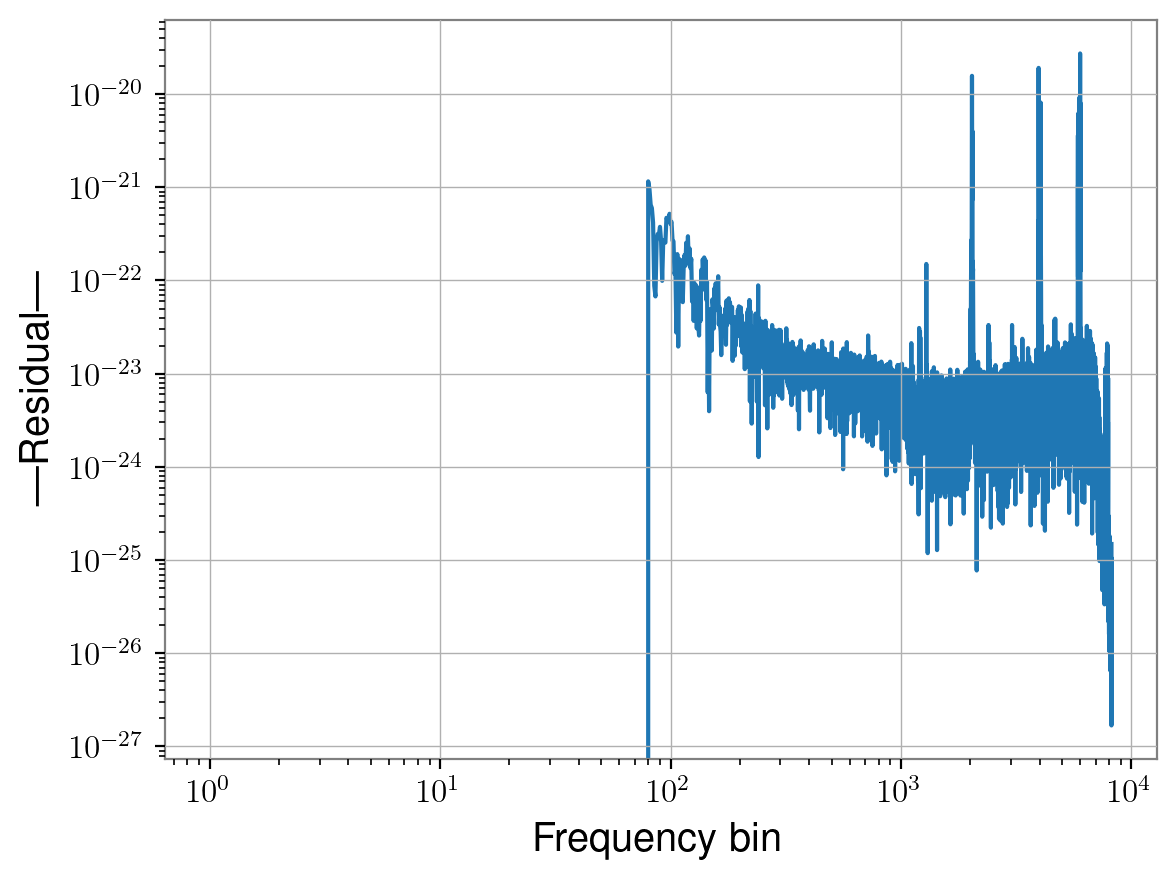

In [7]:
# Plot residual spectrum (magnitude)
plt.plot(np.abs(result['H1']['residual_fd']))
plt.yscale('log')
plt.xscale('log')
plt.ylabel('|Residual|')
plt.xlabel('Frequency bin')

Text(0.5, 0, 'Frequency bin')

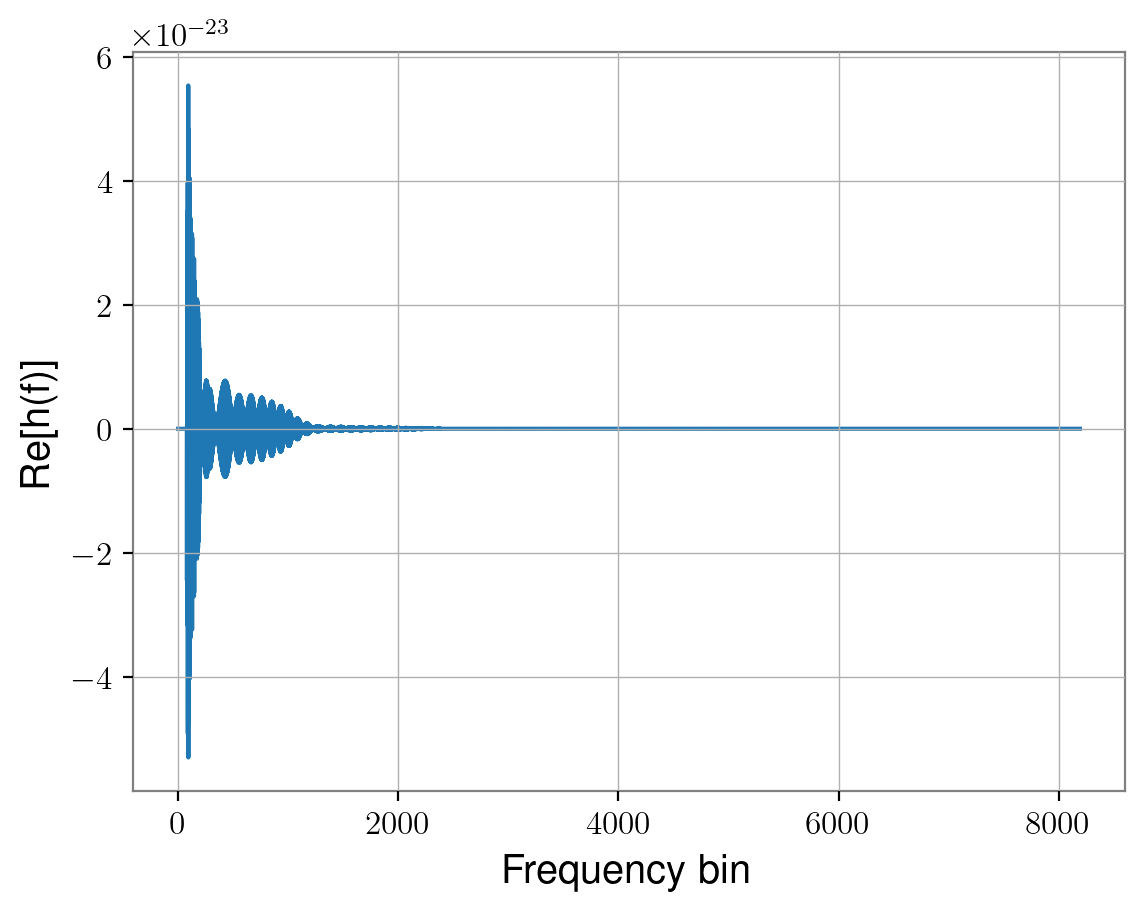

In [8]:
# Plot model waveform (real part)
plt.plot(np.real(result['H1']['model_fd']))
plt.ylabel('Re[h(f)]')
plt.xlabel('Frequency bin')

# Let's try the surrogate

In [10]:
import sys
sys.path.append('..')

In [11]:
from utils import evaluate_surrogate, compute_angular_factors, compute_memory_correction

lal.MSUN_SI != Msun


In [12]:
path_to_surrogate = "../data/NRSur7dq4.h5"
sample = res["samples"][0]

evaluate the surrogate

In [13]:
h_modes, t = evaluate_surrogate(path_to_surrogate, sample)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '../data/NRSur7dq4.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

precompute angular integral factors

In [ ]:
angular_factors = compute_angular_factors()

compute the memory

In [ ]:
h_memory = compute_memory_correction(h_modes, t, angular_factors=angular_factors, return_memory_only=True)

plot it!

/Users/keefemitman/Desktop/Research/MemoryPop/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/keefemitman/Desktop/Research/MemoryPop/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


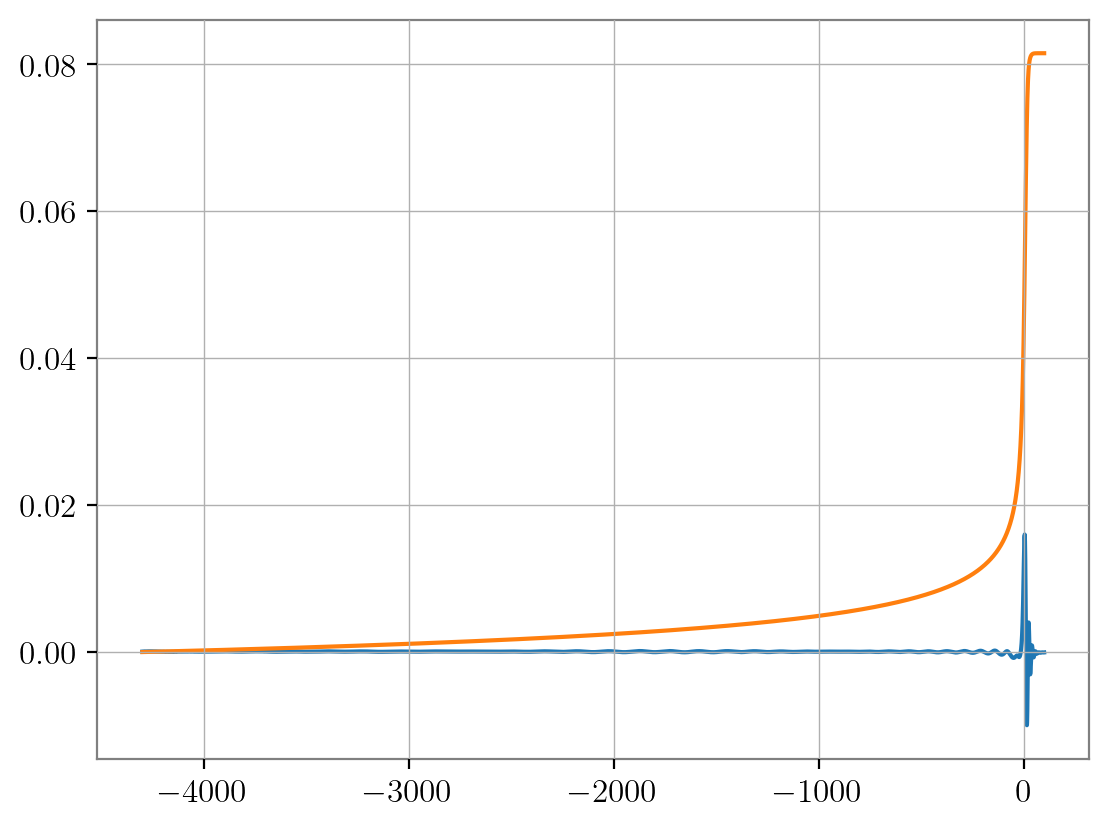

In [ ]:
plt.plot(t, h_modes[(2,0)])
plt.plot(t, h_memory[(2,0)])

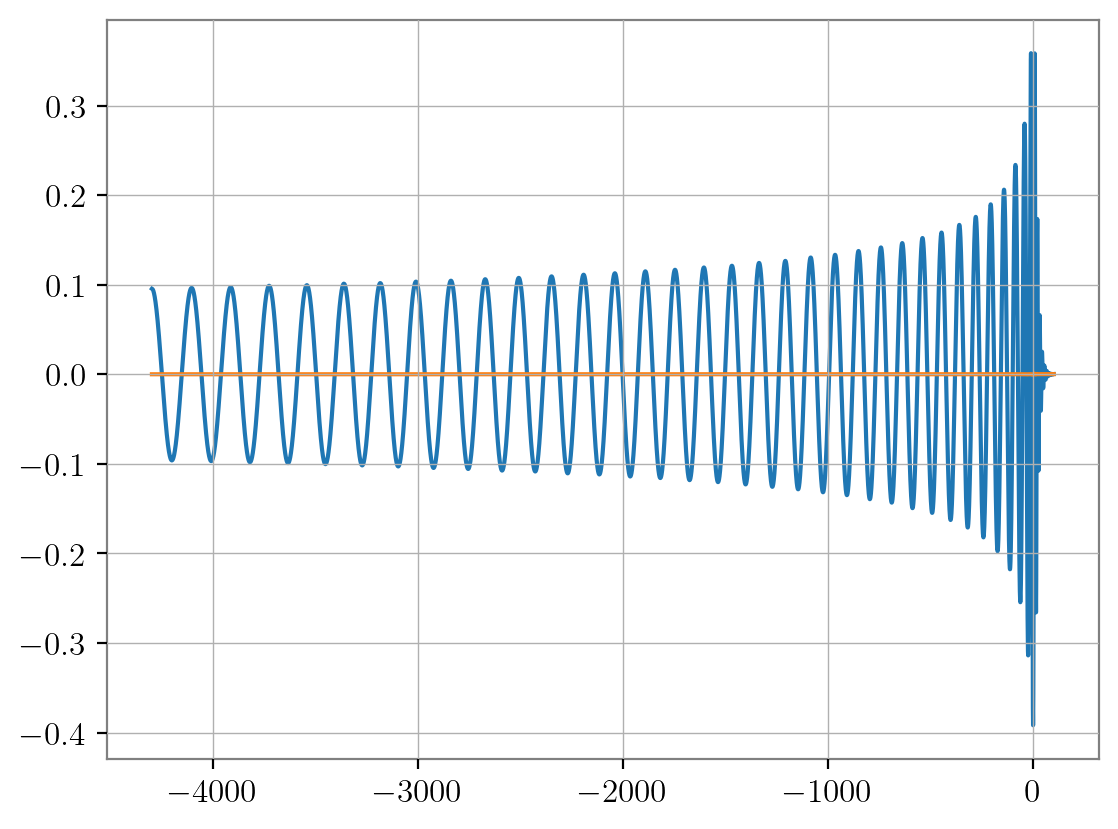

In [ ]:
plt.plot(t, h_modes[(2,2)])
plt.plot(t, h_memory[(2,2)])